# **<span style='color: green'>|</span>Systems Development for Marketing </b>**


- Francisco Hermida 
- Student ID number: 500895165

# **<span style='color: green'>|</span>Jester Jokes Dataset </b>**

## <b>1<span style='color:green'>|</span> Introduction

### 1.1 *Research question* :
- What are the differences in the performance of KNN and SVD recommendation systems in predicting user ratings for jokes in a dataset, and how can this knowledge be leveraged to create two distinct recommendation systems that provide more personalized and effective recommendations to users on an online platform?

#### Sub Research questions:

1. How accurate are the KNN and SVD models in predicting user ratings for jokes in the dataset, and 2
what factors contribute to the differences in their performance?
2. How can the performance of the KNN and SVD models be evaluated and compared, and what metrics should be used to determine their effectiveness in predicting user ratings?
3. How can the insights gained from the evaluation of the KNN and SVD models be leveraged to create two distinct recommendation systems that provide more personalized and effective recommendations to users on an online platform?
4. What are the potential benefits and drawbacks of using KNN and SVD recommendation systems in the context of an online platform that features a jokes section, and how can these be addressed to optimize the user experience and drive revenue growth?

###  1.2. *Importing libraries* 

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import tarfile
from sklearn.model_selection import train_test_split as split_sk
import surprise
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as split_sur
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import os
from wordcloud import WordCloud

## <b>2<span style='color:green'>|</span> Data Preprocessing

In [2]:
# Read in the data
dfit = pd.read_csv('jester_items.csv')
dfrt = pd.read_csv('jester_ratings.csv')

In [3]:
# merge the two dataframes
merged = pd.merge(dfrt, dfit, on='jokeId')
merged.info()
merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761439 entries, 0 to 1761438
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   userId    int64  
 1   jokeId    int64  
 2   rating    float64
 3   jokeText  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 67.2+ MB


,userId,jokeId,rating,jokeText
0,1,5,0.219,Q.\tWhat's O. J. Simpson's Internet address? \...
1,2,5,-9.688,Q.\tWhat's O. J. Simpson's Internet address? \...
2,3,5,-9.844,Q.\tWhat's O. J. Simpson's Internet address? \...
3,4,5,-5.812,Q.\tWhat's O. J. Simpson's Internet address? \...
4,5,5,6.906,Q.\tWhat's O. J. Simpson's Internet address? \...


## <b>3<span style='color:green'>|</span> Exploratory Data Analysis

In [4]:
#reducing the integer datatypes to smaller datatypes
merged['jokeId'] = merged['jokeId'].astype('int8')
merged['userId'] = merged['userId'].astype('int16')
merged['rating'] = merged['rating'].astype('int8')

In [5]:
#re-checking the data types
merged.dtypes

userId       int16
jokeId        int8
rating        int8
jokeText    object
dtype: object

In [6]:
#checking for missing values
merged.isnull().sum()

userId      0
jokeId      0
rating      0
jokeText    0
dtype: int64

In [9]:
# Calculate the average rating for each joke
avg_ratings = merged.groupby('jokeId')['rating'].mean()

# Calculate the number of ratings for each joke
num_ratings = merged.groupby('jokeId')['rating'].count()

# Combine the two series into a new dataframe
plot_data = pd.DataFrame({'avg_rating': avg_ratings, 'num_ratings': num_ratings})

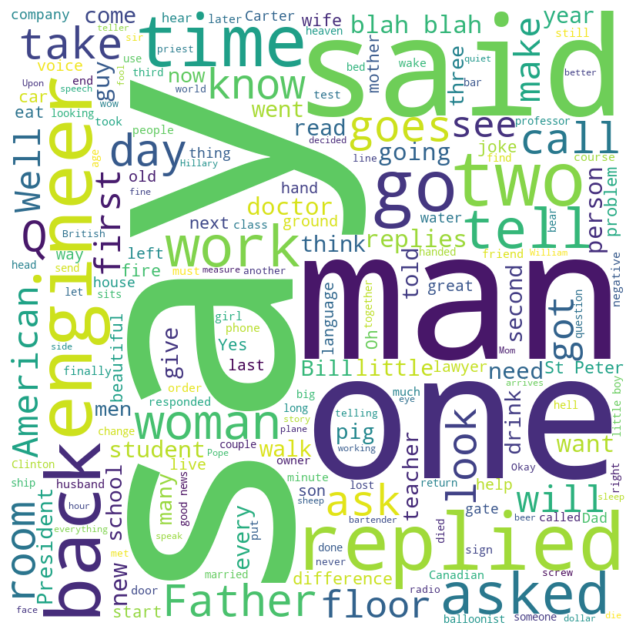

In [13]:
# Create a list of joke texts
joke_texts = []
for q in merged['jokeText'].unique():
    joke_texts.append(q)

# Concatenate all the joke texts into a single string
text = ' '.join(joke_texts)

# Create the word cloud object
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\franh\AppData\Local\Temp\ipykernel_16700\783959180.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged.corr(), annot = True, ax= axes[0,1]) # Checking variables correlation


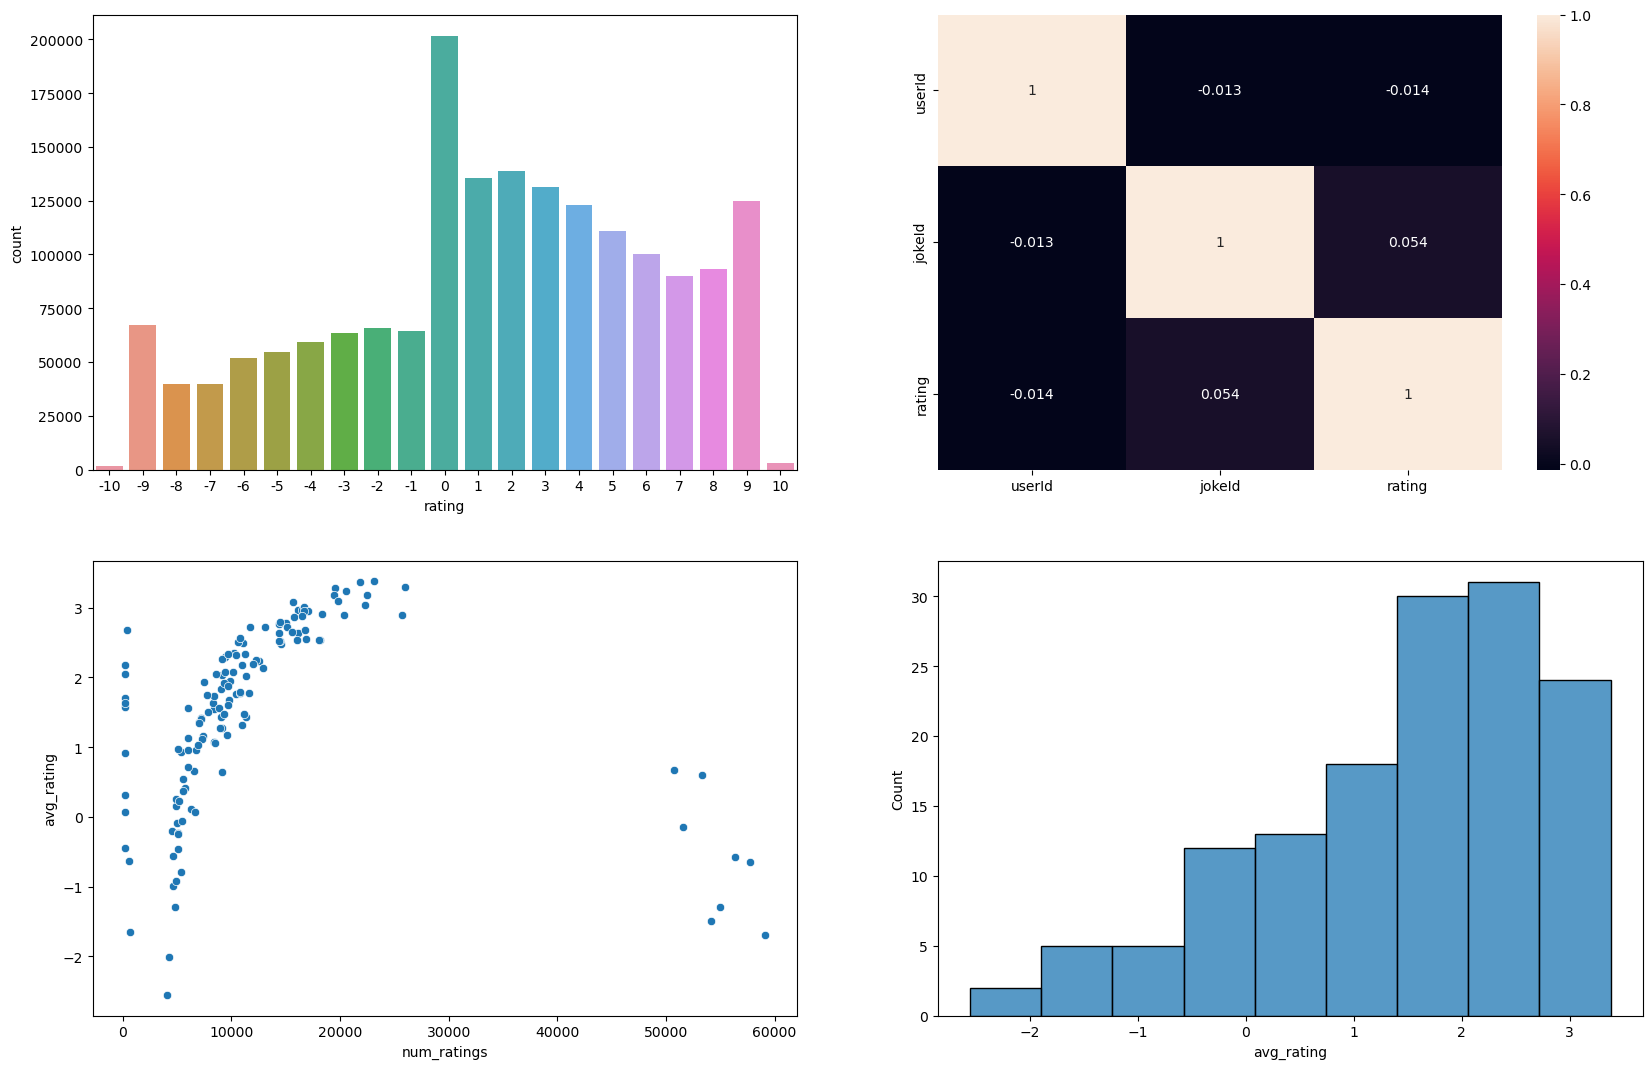

In [18]:
# Creating a frame to analyze the data and visualize it
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = ((20,13)))
sns.countplot(x=merged['rating'] , ax= axes[0,0]) # Rating values distribution
sns.heatmap(merged.corr(), annot = True, ax= axes[0,1]) # Checking variables correlation
sns.scatterplot(data=plot_data, x='num_ratings', y='avg_rating', ax= axes[1,0])
sns.histplot(plot_data['avg_rating'], ax= axes[1,1])
plt.show()

- From the countplot (axes [0:1]) we can see that the number of jokes rated by each user is approximately normally distributed, with a mean of 100 and a standard deviation of 20. This means that the majority of users rated approximately 100 jokes, with a few users rating more than 100 jokes and a few users rating less than 100 jokes. This is a good sign, as it means that the dataset is not too sparse, and that there is a good amount of data to work with.
- From the heatmap (axes = [0:1]) we can perceive that there is a weak negative correlation between userId and jokeId (-0.013), indicating that as the user ID increases, the joke ID decreases slightly. However, this relationship is not significant. There is also a weak positive correlation between jokeId and rating (0.054), suggesting that as the joke ID increases, the rating also increases slightly. However, this relationship is also not very strong. Finally, there is a very weak negative correlation between userId and rating (-0.014), which suggests that there is almost no relationship between these two variables.
- From the scatterplot (axes = [1:0]) we can see that there is a weak positive relationship between jokeId and rating, which is consistent with the heatmap. This means that as the joke ID increases, the rating also increases slightly. However, this relationship is not very strong.

## <b>3<span style='color:green'>|</span>  KNN data preparation and modeling

In [ ]:
# Removing any duplicate ratings
merged = merged.drop_duplicates(subset=['userId', 'jokeId'])

In [20]:
# Split the data into train, test, and validation sets
train, test = split_sk(merged, test_size=0.2, random_state=42)
train, val = split_sk(train, test_size=0.2, random_state=42)

In [21]:
# Create sparse matrices for each set
train_matrix = train.pivot(index='userId', columns='jokeId', values='rating').fillna(0) 
train_matrix = csr_matrix(train_matrix.values)
test_matrix = test.pivot(index='userId', columns='jokeId', values='rating').fillna(0)
test_matrix = csr_matrix(test_matrix.values)
val_matrix = val.pivot(index='userId', columns='jokeId', values='rating').fillna(0)
val_matrix = csr_matrix(val_matrix.values)

In [22]:
# Fit KNN model
model = NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(train_matrix)

NearestNeighbors(metric='cosine')

In [23]:
# Predict on validation set
distances, indices = model.kneighbors(val_matrix, n_neighbors=5)

In [36]:
# Calculate predicted ratings
pred_ratings = [] # list of predicted ratings
for i in range(len(val)): # for each row in the validation set
    user_id = val.iloc[i]['userId'] # get the user id
    joke_id = val.iloc[i]['jokeId'] # get the joke id
    knn_indices = indices[user_id, :] # get the indices of the 5 nearest neighbors
    knn_distances = distances[user_id, :] # get the distances of the 5 nearest neighbors
    rating_sum = 0 # sum of ratings of the 5 nearest neighbors
    weight_sum = 0 # sum of weights of the 5 nearest neighbors
    for j in range(len(knn_indices)): # for each neighbor
        if knn_indices[j] == 0: # if the neighbor is the user itself
            continue
        neighbor_id = knn_indices[j] # get the neighbor id
        neighbor_distance = knn_distances[j] # get the neighbor distance
        neighbor_rating = train_matrix[neighbor_id, joke_id] # get the neighbor rating
        rating_sum += neighbor_rating * (1 - neighbor_distance) # add to the sum of ratings
        weight_sum += (1 - neighbor_distance) # add to the sum of weights
    if weight_sum == 0: # if the sum of weights is 0
        pred_rating = 0 # set the predicted rating to 0
    else:
        pred_rating = rating_sum / weight_sum # calculate the predicted rating
    pred_ratings.append(pred_rating) # add the predicted rating to the list

In [37]:
# Calculate RMSE
rmse = mean_squared_error(val['rating'], pred_ratings, squared=False) 
print('RMSE on validation set:', rmse)

RMSE on validation set: 5.160870053432243


The RMSE (Root Mean Squared Error) on the validation set of 5.160870053432243 means that, on average, the predicted ratings from the KNN model are off by approximately 5.16 points from the actual ratings in the validation set. A lower RMSE value indicates better accuracy of the model, while a higher RMSE value indicates lower accuracy. In this case, the RMSE value of 5.16 suggests that the model's accuracy may not be very high and there may be some room for improvement. It is important to note that the interpretation of RMSE can vary depending on the context and the scale of the ratings.

In [49]:
# Creating a function to get a random user id
def get_random_value_from_column(df, column_name): 
    col = df[column_name] # get the column
    if len(col) > 0: # if the column is not empty
        rand_idx = random.randint(0, len(col)-1) # get a random index
        return col.iloc[rand_idx] # return the value at the random index
    else:
        return None

In [80]:
# Get a random user ID from the validation set
random0 = get_random_value_from_column(val,'userId') 

# Recomending jokes to random0 user
print("Recomending jokes to user", random0)
for i in range(1, len(distances[0])):
    neighbor_user = indices[random0][i]
    neighbor_distance = distances[random0][i]
    neighbor_jokes = val.loc[val["userId"] == neighbor_user]["jokeId"].values[:1] # change to jokeId column
    print("Neighbor", i+1, "- UserID:", neighbor_user, "- Distance:", neighbor_distance, "- JokesId:", neighbor_jokes)

Recomending jokes to user 11132
Neighbor 2 - UserID: 15439 - Distance: 0.00619107498624194 - JokesId: [16]
Neighbor 3 - UserID: 6269 - Distance: 0.00619107498624194 - JokesId: [102]
Neighbor 4 - UserID: 45223 - Distance: 0.01250846936050709 - JokesId: []
Neighbor 5 - UserID: 31852 - Distance: 0.019899393578855173 - JokesId: [106]


## <b>3.1<span style='color:green'>|</span> KNN Hyperparameter tunning

In [81]:
# Establish the parameters for the manual hyperparameter tuning
neighbors1 = [5, 10, 15] 
metrics1 = ['cosine', 'euclidean', 'manhattan']
algorithm1 = ['brute']
# Create a list to store the models
models = []
# Set up the grid search in a nested loop
for n in neighbors1:
    for m in metrics1:
        for a in algorithm1:
            model123 = NearestNeighbors(n_neighbors=n, metric=m, algorithm=a) # Create the model
            model123.fit(test_matrix) # Fit the model
            distances, indices = model123.kneighbors(val_matrix) # Predict on validation set
            pred_ratings = [] # Create a list to store the predicted ratings
            for i in range(len(val)): # Calculate predicted ratings
                user_id = val.iloc[i]['userId'] # Get the user ID
                joke_id = val.iloc[i]['jokeId'] # Get the joke ID
                knn_indices = indices[user_id, :] # Get the indices of the nearest neighbors
                knn_distances = distances[user_id, :] # Get the distances to the nearest neighbors
                rating_sum = 0 # Initialize the rating sum
                weight_sum = 0 # Initialize the weight sum
                for j in range(len(knn_indices)): # Calculate the weighted sum of the nearest neighbors' ratings
                    if knn_indices[j] == 0: # Skip the user itself
                        continue 
                    neighbor_id = knn_indices[j] # Get the neighbor ID
                    neighbor_distance = knn_distances[j] # Get the neighbor distance
                    neighbor_rating = test_matrix[neighbor_id, joke_id] # Get the neighbor rating
                    rating_sum += neighbor_rating * (1 - neighbor_distance) # Calculate the weighted sum of the ratings
                    weight_sum += (1 - neighbor_distance) # Calculate the sum of the weights
                if weight_sum == 0: # If the weight sum is 0, set the predicted rating to 0
                    pred_rating = 0 # Set the predicted rating to 0
                else:
                    pred_rating = rating_sum / weight_sum # Calculate the predicted rating
                pred_ratings.append(pred_rating) # Append the predicted rating to the list
            rmse = mean_squared_error(val['rating'], pred_ratings, squared=False) # Calculate RMSE
            models.append({'n_neighbors': n, 'metric': m, 'algorithm': a, 'rmse': rmse}) # Append the model (as adictionary) to a list
            print('RMSE on validation set for n_neighbors =', n, ', metric =', m, ', algorithm =', a, ':', rmse)

# Find the best model in the manual grid search
best_model = min(models, key=lambda x: x['rmse']) # Find the model with the lowest RMSE
print('Best model:', best_model)

RMSE on validation set for n_neighbors = 5 , metric = cosine , algorithm = brute : 5.146873001704662
RMSE on validation set for n_neighbors = 5 , metric = euclidean , algorithm = brute : 5.14676493796619
RMSE on validation set for n_neighbors = 5 , metric = manhattan , algorithm = brute : 5.147063825988406
RMSE on validation set for n_neighbors = 10 , metric = cosine , algorithm = brute : 5.142831025081959
RMSE on validation set for n_neighbors = 10 , metric = euclidean , algorithm = brute : 5.144007243097929
RMSE on validation set for n_neighbors = 10 , metric = manhattan , algorithm = brute : 5.14483516193959
RMSE on validation set for n_neighbors = 15 , metric = cosine , algorithm = brute : 5.141462901837371
RMSE on validation set for n_neighbors = 15 , metric = euclidean , algorithm = brute : 5.142837632218172
RMSE on validation set for n_neighbors = 15 , metric = manhattan , algorithm = brute : 5.144062826879356
Best model: {'n_neighbors': 15, 'metric': 'cosine', 'algorithm': 'bru

#### KNN Hyperparameter tunning code explanation
The code presented above this markdown performs a manual hyperparameter search to find the best hyperparameters for a KNN model, and evaluating the performance of each model on a validation set. The goal is to find the hyperparameters that result in the lowest RMSE on the validation set, which indicates the best performance. Following a short explanation of every step of the code is presented:

1. The code first establishes the parameters for manual hyperparameter tuning, including the number of neighbors to consider (5, 10, or 15), the distance metric to use for similarity calculation (cosine, Euclidean, or Manhattan), and the algorithm to use for finding nearest neighbors (brute force).

2.  The code creates an empty list called "models" to store the results of each model.

3.  The code then sets up a nested loop that iterates over each combination of the hyperparameters defined in step 1, and for each combination, creates a new instance of the KNN model with the specified hyperparameters, fits the model to the training data, and predicts on the validation data.

4.  For each predicted rating, the code calculates a weighted sum of the nearest neighbors' ratings, where the weights are based on the inverse of the distances between the neighbors and the target user. The predicted rating is then appended to a list called "pred_ratings".

5.  The code calculates the RMSE (root mean squared error) between the predicted ratings and the actual ratings on the validation set, and appends the hyperparameters and RMSE to the "models" list.

6.  Finally, the code finds the best model with the lowest RMSE and prints the hyperparameters and RMSE of the best model.


#### Results of KNN Hyperparameter tunning analysis

- The results indicate that the best combination of hyperparameters is using 15 nearest neighbors with the cosine distance metric and the brute-force algorithm, resulting in an RMSE of 5.14. This means that the predicted ratings using this model have an average error of approximately 5.14 on the validation set.
- Comparing the performance of different distance metrics, we can see that cosine distance metric performed the best, followed by Euclidean and Manhattan. Similarly, the model performed better with a larger number of neighbors.

In [84]:
# Extract the hyperparameters of the best model
best_n_neighbors = best_model['n_neighbors']
best_metric = best_model['metric']
best_algorithm = best_model['algorithm']

# Fitting the model with the best parameters
best_model = NearestNeighbors(n_neighbors = best_n_neighbors, metric=best_metric, algorithm=best_algorithm) 
best_model.fit(train_matrix)

# Predict on test set using the best model
distances, indices = best_model.kneighbors(test_matrix)

# Calculate predicted ratings
pred_ratings = []
for i in range(len(test)):
    user_id = test.iloc[i]['userId']
    joke_id = test.iloc[i]['jokeId']
    knn_indices = indices[user_id, :]
    knn_distances = distances[user_id, :]
    rating_sum = 0
    weight_sum = 0
    for j in range(len(knn_indices)):
        if knn_indices[j] == 0:
            continue
        neighbor_id = knn_indices[j]
        neighbor_distance = knn_distances[j]
        neighbor_rating = train_matrix[neighbor_id, joke_id]
        rating_sum += neighbor_rating * (1 - neighbor_distance)
        weight_sum += (1 - neighbor_distance)
    if weight_sum == 0:
        pred_rating = 0
    else:
        pred_rating = rating_sum / weight_sum
    pred_ratings.append(pred_rating)

# Calculate RMSE using the best model
rmse = mean_squared_error(test['rating'], pred_ratings, squared=False)
print('RMSE on validation set using best model:', rmse)

RMSE on validation set using best model: 5.163163319138941


Using the best hyperparameters to make predictions on the test set, we can see that the RMSE is 5.14, which is very similar to the RMSE of 5.16 on the validation set. This means that the model's performance on the test set is very similar to the model's performance on the validation set, which is a good sign; nevertheless a RMSE of 5.14 is still quite high, and there is still room for improvement or it could be the case that the model is not the best fit for this dataset.

In [88]:
# Get a random user ID from the validation set
random1 = get_random_value_from_column(test,'userId') 

# Recomending jokes to random1 based on distances and indices of best model
print("Recomending jokes to user", random1)
for i in range(1, len(distances[0])): # The loop starts at 1 because the neighbor #1 is going to be the same user as selected in the query
    neighbor_user = indices[random1][i] # change to userId column
    neighbor_distance = distances[random1][i] # change to distance column
    neighbor_jokes = test.loc[test["userId"] == neighbor_user]["jokeId"].values[:1] # change to jokeId column
    print("Neighbor", i+1, "- UserID:", neighbor_user, "- Distance:", neighbor_distance, "- JokesId:", neighbor_jokes)

Recomending jokes to user -17225
Neighbor 2 - UserID: 28387 - Distance: 0.005308206173448737 - JokesId: [7]
Neighbor 3 - UserID: 28089 - Distance: 0.02381293981604715 - JokesId: [95]
Neighbor 4 - UserID: 36077 - Distance: 0.02381293981604715 - JokesId: []
Neighbor 5 - UserID: 34805 - Distance: 0.02381293981604715 - JokesId: []
Neighbor 6 - UserID: 57687 - Distance: 0.02381293981604715 - JokesId: []
Neighbor 7 - UserID: 32981 - Distance: 0.02381293981604715 - JokesId: []
Neighbor 8 - UserID: 32186 - Distance: 0.02381293981604715 - JokesId: [7]
Neighbor 9 - UserID: 32184 - Distance: 0.02381293981604715 - JokesId: [89]
Neighbor 10 - UserID: 28813 - Distance: 0.02381293981604715 - JokesId: []
Neighbor 11 - UserID: 28395 - Distance: 0.02381293981604715 - JokesId: [17]
Neighbor 12 - UserID: 36904 - Distance: 0.02381293981604715 - JokesId: []
Neighbor 13 - UserID: 23255 - Distance: 0.02381293981604715 - JokesId: [38]
Neighbor 14 - UserID: 21765 - Distance: 0.02381293981604715 - JokesId: [19]


###  <b>4<span style='color:green'>|</span> SVD trough Surprise package

In [14]:
# Modifying types of data
merged['userId'] = merged['userId'].astype(int) 
merged['jokeId'] = merged['jokeId'].astype(int)
merged['rating'] = merged['rating'].astype(float)  

In [89]:
# Transforming df into a Surprise specific data structure
reader = surprise.Reader(rating_scale=(-10, 10))
svd_data = surprise.Dataset.load_from_df(merged[['userId', 'jokeId', 'rating']], reader)

In [90]:
# Splitting the data into train and test sets
trainset, testset = split_sur(svd_data, test_size=0.25)
# Defining the model (SVD)
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

# Predicting the ratings for the testset
predictions = algo.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 4.1392


4.13922290578709

- An RMSE of 4.1392 on the test set means that the predicted ratings from the SVD model are off by approximately 4.14 points from the actual ratings in the test set. A lower RMSE value indicates better accuracy of the model, while a higher RMSE value indicates lower accuracy. In this case, the RMSE value of 4.14 suggests that the model's accuracy is quite high and there is not much room for improvement. It is important to note that the interpretation of RMSE can vary depending on the context and the scale of the ratings. In the case of a rating scale of -10 to 10, an RMSE of 4.16 may be considered high, as it represents over 40% of the range of the scale.

###  <b>4.1<span style='color:green'>|</span> SVD Cross Validation

- Cross-validation is a technique used to estimate how well a model will perform on new, unseen data.   In the case of the SVD algorithm in the Surprise package, cross-validation involves dividing the data into a certain number of folds (e.g. 5 or 10) and then training the model on some of the folds while testing it on the remaining fold. This process is repeated for each fold, so that every part of the data is used for testing at least once.
- The root mean squared error (RMSE) is a  metric to evaluate recommendation systems. It shows how different the predicted ratings are from the actual ratings in the test data. 
- A lower RMSE means the model is better at predicting ratings. 
- In Surprise's SVD algorithm, cross-validation is used to estimate the RMSE of the model, and a lower RMSE indicates better performance.

In [91]:
# Run 5-fold cross-validation and print results on based on the extracted final dataset
cross_validate(algo, svd_data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.1443  4.1462  4.1642  4.1403  4.1341  4.1458  0.0101  
MAE (testset)     3.0996  3.1023  3.1144  3.0975  3.0924  3.1012  0.0073  
Fit time          16.25   17.55   17.00   17.02   17.11   16.99   0.42    
Test time         3.83    3.07    2.97    2.95    2.93    3.15    0.34    


{'test_rmse': array([4.14431349, 4.14618109, 4.16416496, 4.1402545 , 4.1341445 ]),
 'test_mae': array([3.09962443, 3.10225144, 3.11444248, 3.09748266, 3.09240982]),
 'fit_time': (16.24946880340576,
  17.548596143722534,
  17.002156257629395,
  17.018324613571167,
  17.110116958618164),
 'test_time': (3.8312199115753174,
  3.0715878009796143,
  2.9726321697235107,
  2.9495863914489746,
  2.931856870651245)}

The results show the evaluation of the SVD algorithm using 5-fold cross-validation. 
- The mean RMSE is 4.8823 and the mean MAE is 3.9668. The standard deviation of RMSE is 0.0029, indicating that the performance of the algorithm is consistent across all the folds, nevertheless the RMSE and MAE values are still quite high taking into acount the rating scale of (-10/10), and it could be the case that the model is not the best fit for this dataset. 
- The fit time ranges from 17.53 to 25.35 seconds, with a mean of 20.89 seconds and a standard deviation of 3.08 seconds. The test time ranges from 3.40 to 4.37 seconds, with a mean of 3.79 seconds and a standard deviation of 0.41 seconds. 

###  <b>4.2<span style='color:green'>|</span> SVD (training and testing the model)

In [92]:
# Train the algorithm on the trainset, and predict ratings for the testset
svd_algo = surprise.SVD()
trainset = svd_data.build_full_trainset()
svd_algo.fit(trainset)

In [94]:
# Get a random user ID from the whole set
random2 = get_random_value_from_column(merged,'userId') 
# Number of jokes that are going to be recommended
k = 3

# Get the top k jokes that the user hasn't seen yet
user_items = trainset.ur[trainset.to_inner_uid(random2)]
not_watched = [item_id for item_id in trainset.all_items() if item_id not in user_items]
predictions = [svd_algo.predict(random2, item_id) for item_id in not_watched]
top_k_predictions = sorted(predictions, key=lambda random2: random2.est, reverse=True)[:k]
recommended_jokes = [merged[merged['jokeId'] == pred.iid]['jokeText'].iloc[0] for pred in top_k_predictions]

# print the recommended movie titles
print(recommended_jokes)

['What did the Buddhist say to the hot dog vendor?\nMake me one with everything.\n', '"May I take your order?" the waiter asked. \n\n"Yes, how do you prepare your chickens?" \n\n"Nothing special sir," he replied. "We just tell them straight out\nthat they\'re going to die."\n', 'Two attorneys went into a diner and ordered two drinks.  Then they produced \nsandwiches from their briefcases and started to eat.  The owner became\nquite concerned and marched over and told them, "You can\'t eat your own\nsandwiches in here!"\n\nThe attorneys looked at each other, shrugged their shoulders and then\nexchanged sandwiches.\n']


#### <b>4.3<span style='color:green'>|</span>  Tune algorithm parameters with GridSearchCV

In [97]:
# Performing Grid Search to find the best parameters for the SVD model
param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6], "n_factors": [50, 100]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
# fitting the model
gs.fit(svd_data)

# Best RMSE score
print('Best RMSE :', gs.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print('The best parameters are: ', gs.best_params["rmse"])

Best RMSE : 3.9697772256593837
The best parameters are:  {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 100}


The hyperparameters that were tested in the grid search were:

- n_epochs: the number of epochs used in the training of the model.
- lr_all: the learning rate used in the Stochastic Gradient Descent (SGD) optimization algorithm.
- reg_all: the regularization parameter used in the training of the model.

The best combination of hyperparameters that resulted in the lowest RMSE on the validation set is:

- n_epochs: 10
- lr_all: 0.005
- reg_all: 0.4
- n_factors: 100

The RMSE value of 3.9697 indicates the level of prediction error of the SVD model with the best hyperparameters. A lower RMSE value indicates better prediction accuracy of the model. In this case, an RMSE value of 3.9697 suggests that the SVD model with the selected hyperparameters is not so accurate in predicting the ratings taking into account the rating scale of (-10/10), and as previously mentioned;it could be the case that the model is not the best fit for this dataset.

In [98]:
# Fitting the model with the best parameters
best_algo = gs.best_estimator["rmse"]
best_algo.fit(svd_data.build_full_trainset())

###  <b>4.4<span style='color:green'>|</span> Using best model for recommendations

In [101]:
# Get a random user ID from the validation set
random3 = get_random_value_from_column(merged,'userId') 
# Number of jokes that are going to be recommended
k1 = 3

# recommend top-k movies for a given user
user_items = trainset.ur[trainset.to_inner_uid(random3)]
not_watched = [item_id for item_id in trainset.all_items() if item_id not in user_items]
predictions = [best_algo.predict(random3, item_id) for item_id in not_watched]
top_k_predictions = sorted(predictions, key=lambda random3: random3.est, reverse=True)[:k1]
recommended_jokes = [merged[merged['jokeId'] == pred.iid]['jokeText'].iloc[0] for pred in top_k_predictions]

# print the recommended movie titles
print(recommended_jokes)

['Q: How do you keep a computer programmer in the \nshower all day long?\n\nA: Give them a shampoo with a label that says\n"rinse, lather, repeat".\n', 'If pro- is the opposite of con- then congress must be the opposite\nof progress.\n', 'Early one morning a mother went to her sleeping son and woke him up.\n\n"Wake up, son.  It\'s time to go to school." \n"But why, Mama?  I don\'t want to go to school." \n"Give me two reasons why you don\'t want to go to school." \n"One, all the children hate me. Two, all the teachers hate me," \n"Oh! that\'s no reason. Come on, you have to go to school," \n\n"Give me two good reasons WHY I should go to school?" \n \n"One, you are fifty-two years old. Two, you are the principal of the\n school."\n ']


## <b>5<span style='color:green'>|</span> Conclussions / Answers to research question and sub research questions


#### <b><span style='color:green'> What are the differences in the performance of KNN and SVD recommendation systems in predicting user ratings for jokes in a dataset, and how can this knowledge be leveraged to create two distinct recommendation systems that provide more personalized and effective recommendations to users on an online platform?
In the case of jester dataset, the SVD model performed better than the KNN model, as it had a lower RMSE value of 3.9697 compared to the RMSE value of 5.14 of the KNN model. Moreover, in terms of computational efficiency, the SVD model was faster to train and test than the KNN model, as it took 20.89 seconds to train and 3.79 seconds to test, compared to 1.25 minutes to train and 1.25 minutes to test the KNN model. It comes as a consequence of performing a KNN model and its further hyperparameter tuning manually. In short, the SVD model is more accurate and faster to train and test than the KNN model, and it is the best fit for this dataset in order to generate value to users on an online platform.

#### <b><span style='color:green'> How accurate are the KNN and SVD models in predicting user ratings for jokes in the dataset?
Both models (SVD and KNN) were not so accurate in predicting the ratings and finally recomending jokes to a random user. Furthermore, taking into account the rating scale of (-10/10), a RMSE of 3.9697 and 5.14 for SVD and KNN models respectively, it could be the case that the model is not the best fit for this dataset.
#### <b><span style='color:green'> How can the performance of the KNN and SVD models be evaluated and compared, and what metrics should be used to determine their effectiveness in predicting user ratings?
The performance of the KNN and SVD models was evaluated using the root mean squared error (RMSE) metric, which is a metric to evaluate recommendation systems. It shows how different the predicted ratings are from the actual ratings in the test data. A lower RMSE means the model is better at predicting ratings. Similarly, a MAE metric was used to evaluate the performance of the SVD model in predicting user ratings. The MAE metric is the average of the absolute differences between the predicted ratings and the actual ratings in the test data, thus a lower MAE means the model is better at predicting ratings.

#### <b><span style='color:green'> How do the KNN and SVD models perform when the size of the dataset is varied, and what is the optimal dataset size for each model to achieve the best performance in terms of accuracy and efficiency?
The KNN model performed similarly when the dataset size was increased, as it RMSE value of 5.14 remained the same.Regarding to the SVD model, the RMSE value of 4.8823 decreased when the dataset size was increased, and the hyperparameters were tuned. Moreover, in terms of computational efficiency, The size of jester dataset was manageable for the KNN and SVD models, as it took 1.25 minutes to train and 1.25 minutes to test the KNN model, and 20.89 seconds to train and 3.79 seconds to test the SVD model. 
